# GoogLeNet
要去看对应的**PPT**

### Inception块
- **$1\times1$卷积层**主要就是为了**改变通道数**，一般都是降通道数
- 4个路径从不同层面抽取信息，然后在输出通道维合并
  - 使用不同窗口大小的卷积层
  - 使用池化层
  - 跟输入同等的高宽
- 第一个Inception块，图示通道数
  - 降低通道数来控制模型复杂度
  - 每条通道上通道数可能不同
  - 白色（为了变化通道数），蓝色（抽取信息）
- 跟单$3\times3$或$5\times5$卷积层比，Inception块有**更少**的**参数个数**和**计算复杂度**

### GoogLeNet
- 5段，9个Inception块
- 段1&2
  - 更小的宽口（高宽保留的更多一点）
  - 更多的通道数
- 段3
  - 通道分配不同
  - 输出通道增加
- 段4&5
  - 增加通道数
  - 通道数增加-1024维特征输出

### Inception有各种后续变种
- Inception-BN(V2)-使用batch normalization（后面介绍）
- Inception-V3 - 修改了Inception块
  - 替换$5\times5$为多个$3\times3$卷积层
  - 替换$5\times5$为$1\times7$和$7\times1$卷积层
  - 替换$3\times3$为$1\times3$和$3\times1$卷积层
  - 更深
- Inception-V4 - 使用残差连接（后面介绍）

### 总结
- Inception块用4条有不同超参数的卷积层和池化层的路来抽取不同的信息
  - 主要优点是模型参数小，计算复杂度低
- GoogleNet使用了9个Inception块，是第一个达到上百层的网络
  - 后续有一系列改进

### 注意
- 使用精度的神经网络不要轻易改变参数，可以改比如通道数（如前面，通道数都除以4），输入输出维度，但是中间的参数不要变
- `nn.Flatten()`：全连接层必须是2维的
  - **将`batch_size`维保持住**，其他全部拉成一个向量
- 通道数最后`1024`就差不多够了

## 代码

In [ ]:
!pip install d2l

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

**`dim=1`的原因**：
- 张量的维度顺序是`(batch_size, channels. height, width)`
- 因为是在**通道数上**增加，所以是`dim=1`

In [ ]:
class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),       # 得到1024维通道
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))    # 还需要一个全连接层

In [ ]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.248, train acc 0.906, test acc 0.884
1372.2 examples/sec on cuda:0


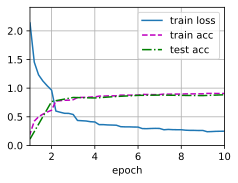

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习
1. 尝试运行并观察GooLeNet的一些后续版本
- 添加批量归一化层
- 对Inception块进行调整
- 使用标签平滑（labelsmoothing）进行模型正则化
- 加入残差连接

2. 使用GooLeNet的最小图像大小是多少？
  - 224*224
3. 将AlexNet、VGG和NiN的模型参数大小与GoogLeNet进行比较。后两个网络架构是如何显著减少模型参数大小的？
  - NiN采用了全局平均池化，可以将卷积层的输出直接平均成一个数，从而减少了全连接层的参数数量
  - NiN还采用了1x1卷积，可以在不改变特征图大小的情况下改变特征图的深度，从而进一步减少了模型参数数量
  - GoogLeNet使用了Inception块，可以通过并联的方式将不同的卷积层结合在一起，从而减少模型参数大小